In [1]:
# importing the required modules
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Activation, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_DIR = '../models'  # Directory to save the model
MODEL_PATH = os.path.join(MODEL_DIR, 'simple_CNN_ctr_RGB.keras')  # Path to save the trained model
DATASET_PATH = '../data/subimages_for_modeling/modeling_set_ctr_mod'  # Path to the dataset

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.


In [3]:
# build the architecture of my model
from tensorflow.keras import backend as K
K.clear_session() # clear the cache of model parameters

# Define the model architecture
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(filters=6, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    
    Flatten(),
    Dropout(rate=0.5),  # Adding a dropout layer with a dropout rate of 50%
    Dense(units=2, activation='softmax')
])


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73926)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73926)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       147,854 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,022 (578.21 KB)

 Trainable params: 148,022 (578.21 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# compile the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['precision'])

In [6]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)
print(f"Model saved at {MODEL_PATH}")

Epoch 1/20


/Users/mimmo/Desktop/neuefische/Automated-recognition-of-NETs/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.4500 - precision: 0.8429
Epoch 1: val_loss improved from inf to 0.21947, saving model to ../models/simple_CNN_ctr_RGB.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.4472 - precision: 0.8441 - val_loss: 0.2195 - val_precision: 0.9333
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1966 - precision: 0.9212
Epoch 2: val_loss improved from 0.21947 to 0.15987, saving model to ../models/simple_CNN_ctr_RGB.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.1964 - precision: 0.9215 - val_loss: 0.1599 - val_precision: 0.9548
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0918 - precision: 0.9770
Epoch 3: val_loss improved from 0.15987 to 0.11482, saving model to ../models/simple_CNN_ctr_RGB.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0922 - precision: 0.9767 - val_loss: 0.1148 - val_precision: 0.9763
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0784 - precision: 0.9878
Epoch

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Classification Report:
                   precision    recall  f1-score   support

    NET_negative       0.63      0.63      0.63       285
NET_positive_ctr       0.41      0.41      0.41       180

        accuracy                           0.54       465
       macro avg       0.52      0.52      0.52       465
    weighted avg       0.54      0.54      0.54       465



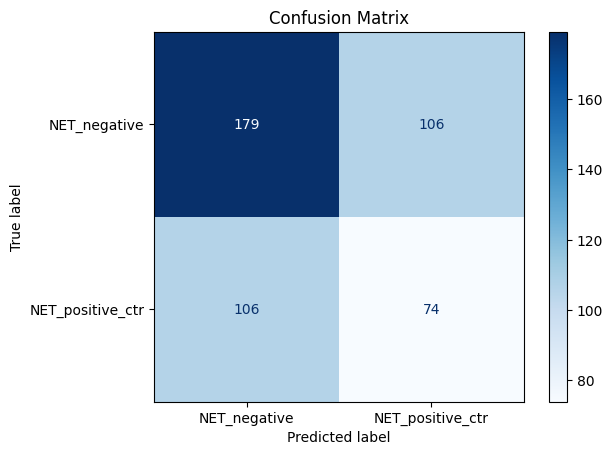

In [7]:
# get the metrics
# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'Precision': tf.keras.metrics.Precision})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

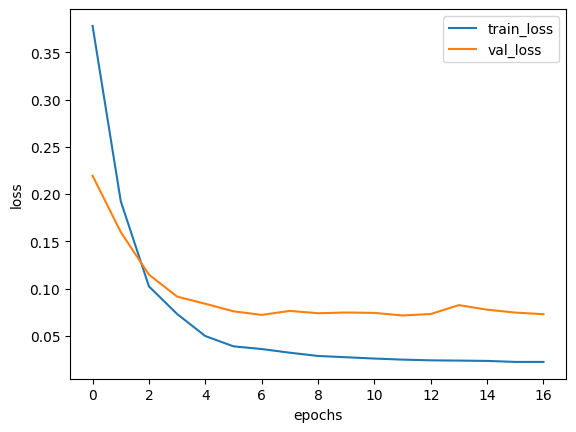

In [8]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [9]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=IMG_SIZE):
    # Load the image with the target size
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Expand dimensions to match the shape the model expects (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Rescale the image by dividing by 255
    img_array = img_array / 255.0
    return img_array

# Function to make and decode the prediction
def predict_image(image_path, model):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    # Make the prediction
    prediction = model.predict(preprocessed_image)
    # Decode the prediction
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class, prediction

# Example usage
image_path = '../data/subimages_for_modeling/NET_positive_ctr/20211111.lif_ctr 3.11.21NET488_MPO633_006.tif_sub_image_60.png'  # Replace with the path to your image

# Ensure the image path exists
if os.path.exists(image_path):
    predicted_class, prediction = predict_image(image_path, model)
    print(f"Predicted class: {predicted_class}")
    print(f"Prediction probabilities: {prediction}")
else:
    print(f"The specified image path does not exist: {image_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: [1]
Prediction probabilities: [[0.00252484 0.9974751 ]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
                                            Filename  TrueLabel  \
0  NET_negative/20211111.lif_ctr 3.11.21NET488_MP...          0   
1  NET_negative/20211111.lif_ctr 3.11.21NET488_MP...          0   
2  NET_negative/20211111.lif_ctr 3.11.21NET488_MP...          0   
3  NET_negative/20211111.lif_ctr 3.11.21NET488_MP...          0   
4  NET_negative/20211111.lif_ctr 3.11.21NET488_MP...          0   

   ProbCategory0  ProbCategory1  
0       0.999988   1.237016e-05  
1       0.999995   5.055252e-06  
2       1.000000   3.119891e-07  
3       0.999725   2.746146e-04  
4       0.000051   9.999493e-01  
Classification Report:
                   precision    recall  f1-score   support

    NET_negative       0.64      0.64      0.64       285
NET_positive_ctr       0.43      0.43      0.43       180

        accuracy                           0.56       465
       macro avg       0.54      0.54      0.54       465
    weighted avg       0.56      0.56

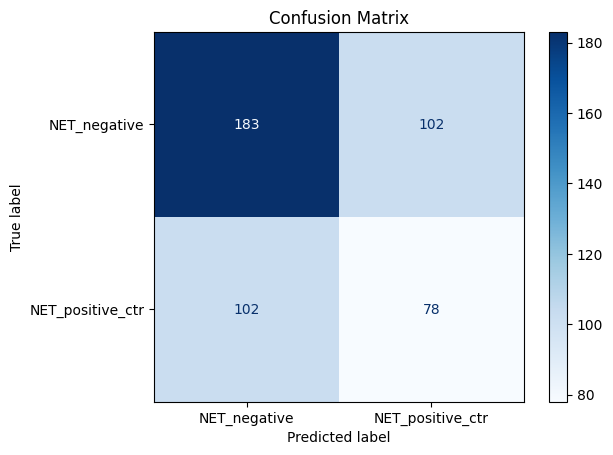

In [10]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Constants
MODEL_PATH = '../models/simple_CNN_ctr_RGB.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '../data/subimages_for_modeling/modeling_set_ctr_mod'
THRESHOLD = 0.25  # Custom threshold for category 2

# Load the trained model with custom objects if any
model = load_model(MODEL_PATH, custom_objects={'Precision': tf.keras.metrics.Precision})

# Make predictions
predictions = model.predict(test_generator)

# Apply custom threshold logic to adjust predictions
predicted_classes = np.argmax(predictions, axis=1)  # Default class based on highest probability
#for i in range(len(predictions)):
#    if predictions[i][1] >= THRESHOLD:  # Assuming class 2 corresponds to index 1
#        predicted_classes[i] = 1  # Force into category 2 if probability is >= threshold

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Create a DataFrame with image filenames, true labels, and predicted probabilities
filenames = test_generator.filenames
prob_category_0 = predictions[:, 0]
prob_category_1 = predictions[:, 1]

data = {
    'Filename': filenames,
    'TrueLabel': true_classes,
    'ProbCategory0': prob_category_0,
    'ProbCategory1': prob_category_1
}

df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
df.to_csv('predictions_with_probabilities.csv', index=False)

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [11]:
df

,Filename,TrueLabel,ProbCategory0,ProbCategory1
0,NET_negative/20211111.lif_ctr 3.11.21NET488_MP...,0,0.999988,1.237016e-05
1,NET_negative/20211111.lif_ctr 3.11.21NET488_MP...,0,0.999995,5.055252e-06
2,NET_negative/20211111.lif_ctr 3.11.21NET488_MP...,0,1.000000,3.119891e-07
3,NET_negative/20211111.lif_ctr 3.11.21NET488_MP...,0,0.999725,2.746146e-04
4,NET_negative/20211111.lif_ctr 3.11.21NET488_MP...,0,0.000051,9.999493e-01
...,...,...,...,...
460,NET_positive_ctr/aug_4_20211111.lif_ctr_27.10....,1,0.999992,8.259819e-06
461,NET_positive_ctr/aug_4_20211111.lif_ctr_27.10....,1,0.958201,4.179889e-02
462,NET_positive_ctr/aug_4_20211111.lif_ctr_27.10....,1,0.984280,1.572001e-02
463,NET_positive_ctr/aug_4_20211111.lif_ctr_27.10....,1,0.004477,9.955229e-01
